In [1]:
import sys
sys.path.append('../../preLIMinary/')
sys.path.append('/home/gsatopo1/library/lim')

from lim import lim
import numpy as np
import astropy.units as u
import astropy.constants as cu
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy import integrate
import matplotlib
from scipy.optimize import curve_fit
import source.tools._utils as ut
import source.tools._vid_tools as vut
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as clrs
import matplotlib.cm as cmap
import matplotlib.patches as patches
import copy
import pmesh
from astropy.io import fits
import dask.array as da
import astropy.constants as cu
from warnings import warn

import pickle

#kitsune   = '#D9972F'
#seiheki   = '#478384'
#shuan     = '#740A00'
#aonibi      = '#324356'
#shion       = '#968ABD'
#suoko     = '#B23E52'
#shironeri    = '#FCFAF2'


#colors = [suoko,seiheki,kitsune,'#79a43a',aonibi,shion,'#828282']
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
#plt.rcParams['lines.linewidth'] = 3.0
#plt.rcParams['axes.linewidth'] = 2.

#palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#9B88B5', '#5f685f']

from mpl_toolkits.axes_grid1 import make_axes_locatable

LC_path='/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/'

palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

### colormap functions

In [8]:
def makemap(cols):
    cmap = clrs.LinearSegmentedColormap.from_list("", cols)
    return cmap

def dispmap(cols):
    f,axes = plt.subplots(figsize=(8,0.5), dpi=100,sharey=True)
    f.subplots_adjust(wspace=0,right=0.99,top=0.99,bottom=0.00,left=0.01,hspace=0.0)
    plt.yticks([])
    arr=np.tile(np.arange(1000),100).reshape(100,1000)
    cmap = makemap(cols)
    plt.imshow(arr,cmap=cmap)

### Tools

In [2]:
def save_pickle(name,obj):
    '''
    name without extension
    '''
    with open(name+'.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return

def load_pickle(name):
    '''
    name without extensions
    '''
    with open(name+'.pickle', 'rb') as handle:
        obj = pickle.load(handle)
    return obj

def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)


In [4]:
def LC_params(line):
    h=0.678
    zmin = 2.5;zmax = 3.5
    zmid=(zmax+zmin)/2
    R=700
    ang_lim=0.3*u.deg
    model_params=dict(halo_lightcone_dir=LC_path, 
                      do_external_SFR = False, external_SFR = '',
                      SFR_pars=dict(),
                      resampler='cic',
                      angular_supersample=1,
                      spectral_supersample=1,
                      cube_mode='inner_cube',
                      Nmu=20,
                      kmax=3*u.Mpc**-1,
                      dk=0.02*u.Mpc**-1,
                      seed=0)
    obs_params=dict(zmin = zmin-0.03, zmax = zmax+0.03, 
                    RAObs_min=-ang_lim,RAObs_max=ang_lim, DECObs_min=-ang_lim,DECObs_max=ang_lim,
                    RA_min=-ang_lim,RA_max=ang_lim, DEC_min=-ang_lim,DEC_max=ang_lim,
                    Nfeeds=1000, beam_FWHM=2*u.arcmin, tobs=6000*u.hr, do_angular_smooth=True,
                   do_spectral_smooth=True)
    
    if line=='CO':
        nu_CO=115.271*u.GHz
        dnu=nu_CO/(1+zmid)/R
        model_params.update(dict(lines=dict(CO_J10=True), target_line = 'CO_J10',
                                #models=dict(CO_J10=dict(model_name='CO_Li16',
                                #                    model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                                 models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                                          model_pars={'alpha':0.81568736,'beta':3.43531917,'alpha_std':0,'beta_std':0,'sigma_L':0.2})),
                                 LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10),                          
                                 do_intensity=False))
        obs_params.update(dict(nuObs_max=nu_CO/(1+zmin), nuObs_min=nu_CO/(1+zmax),
                           dnu=dnu, 
                           Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='CII':
        nu_CII=1900.539*u.GHz
        dnu=nu_CII/(1+zmid)/R
        model_params.update(dict(lines=dict(CII=True),target_line = 'CII',
                          models=dict(CII=dict(model_name='CII_Lagache18',
                                               model_pars={'alpha1':1.4,'alpha2':-0.07, 'beta1':7.1, 'beta2':-0.07, 'sigma_L':0.5})),
                          do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_CII/(1+zmin), nuObs_min=nu_CII/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='Lyalpha':
        nu_Lya=2465398.5*u.GHz
        dnu=nu_Lya/(1+zmid)/R
        model_params.update(dict(lines=dict(Lyalpha=True),target_line = 'Lyalpha',
                                 models=dict(Lyalpha=dict(model_name='Lyalpha_Chung19',
                                                          model_pars={'C':1.6e42,'xi':1.6,'zeta':0.5,
                                                                      'psi':0.875,'z0':3.125,'f0':0.18,
                                                                      'SFR0':0.5,'sigma_L':0.3})),
                                 do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_Lya/(1+zmin), nuObs_min=nu_Lya/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
        
    elif line=='HI':
        nu_HI=1.4204134*u.GHz
        dnu=nu_HI/(1+zmid)/R
        model_params.update(dict(lines=dict(HI=True),target_line = 'HI',
                                 models=dict(HI=dict(model_name='HI_VN18',
                                                     model_pars={'M0':2.9e9*u.Msun/h, 'Mmin':6.7e10*u.Msun/h, 
                                                                 'alpha':0.76,'sigma_MHI':0.2})),
                                 do_intensity=False))
        obs_params.update(dict(zmin = zmin-0.03, zmax = zmax+0.03,
                               nuObs_max=nu_HI/(1+zmin), nuObs_min=nu_HI/(1+zmax),
                        dnu=dnu,
                        Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    return obs_params


In [5]:
LC_CO=make_measurements(LC_params('CO'))
LC_CO.update(beam_FWHM=4*u.arcmin,dnu=31.25*u.MHz,angular_supersample=20,spectral_supersample=10,do_spectral_smooth=True,do_angular_smooth=True,do_downsample=False)
CO_map = LC_CO.obs_3d_map
LC_CII=make_measurements(LC_params('CII'))
LC_CII.update(beam_FWHM=35*u.arcsec,dnu=5.5*u.GHz,angular_supersample=14,spectral_supersample=10,do_spectral_smooth=True,do_angular_smooth=True,do_downsample=False)
CII_map = LC_CII.obs_3d_map


../../preLIMinary/source/survey.py:328: UserWarning: % of survey volume lost due to inner cube = 0.14078322478668015
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:680: UserWarning: % of emitters of CO_J10 line left out filtering = 0.150087171291588
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))
../../preLIMinary/source/survey.py:328: UserWarning: % of survey volume lost due to inner cube = 0.14078322478668037
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:680: UserWarning: % of emitters of CII line left out filtering = 0.150087171291588
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [12]:
rr = np.linspace(LC_CO.cosmo.comoving_radial_distance(2.5),LC_CO.cosmo.comoving_radial_distance(3.5),10)
zz = LC_CO.cosmo.redshift_at_comoving_radial_distance(rr)
nu_CO=115.271*u.GHz
nu_obs_CO = nu_CO.value/(1+zz)
nu_CII=1900.539*u.GHz
nu_obs_CII = nu_CII.value/(1+zz)


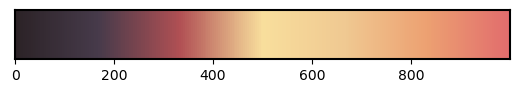

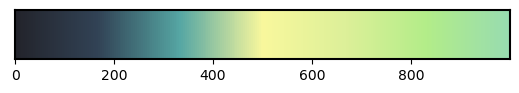

In [9]:
dispmap(['#2c2327','#473b4b',
         '#b15054','#f9df9d','#f0c992','#eda172','#e26d6d'])
dispmap(['#23242c','#324356',
         '#56a7a4','#f9f89d','#ddf099','#b3ed89','#98dcb0'])

In [10]:
warm_negative_map=makemap(['#2c2327','#473b4b'])
warm_negative=[clrs.rgb2hex(warm_negative_map(i)) for i in np.linspace(0,1,5)]
warm_positive=['#b15054','#f9df9d','#f0c992','#eda172','#eda172']
warm=np.concatenate((warm_negative, warm_positive))
warm_map=makemap(warm)

cold_negative_map=makemap(['#23242c','#324356'])
cold_negative=[clrs.rgb2hex(cold_negative_map(i)) for i in np.linspace(0,1,5)]
cold_positive=['#56a7a4','#f9f89d','#ddf099','#b3ed89','#98dcb0']
cold=np.concatenate((cold_negative, cold_positive))
cold_map=makemap(cold)

/home/gsatopo1/library/py3_env/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


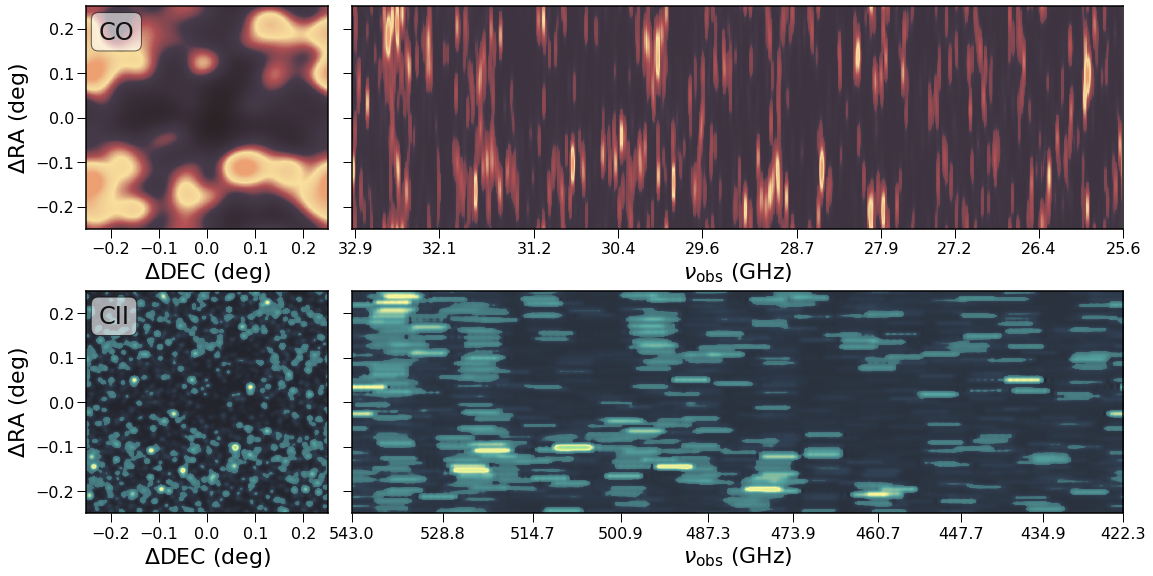

In [13]:
gs_plot = gridspec.GridSpec(2, 4,left=0.07,bottom=0.1,right=0.97,top=0.98,wspace=.1,hspace=.28)
fig = plt.figure(figsize=(16,8))

ax = plt.subplot(gs_plot[0,0])
map_to_plot = CO_map.preview(axes=[1,2])
norm = clrs.TwoSlopeNorm(vcenter=0,vmax=np.max(map_to_plot),vmin=np.min(map_to_plot))
ax.imshow(map_to_plot, extent=(-0.25,0.25,-0.25,0.25),cmap=warm_map,norm=norm,aspect='auto')
ax.set_ylabel(r'$\Delta$RA (deg)',fontsize=22)
ax.set_xlabel(r'$\Delta$DEC (deg)',fontsize=22)
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.set_yticks([-0.2,-0.1,0.,0.1,0.2])
ax.set_xticks([-0.2,-0.1,0.,0.1,0.2])
ax.text(0.05,0.94,'CO',fontsize=24,va='top',ha='left',
      bbox=dict(boxstyle="round",fc='w',ec='k',alpha=0.6),color='k',
      multialignment='center',alpha=0.9,transform=ax.transAxes)

ax = plt.subplot(gs_plot[0,1:])
map_to_plot = CO_map.preview(axes=[1,0])
norm = clrs.TwoSlopeNorm(vcenter=0,vmax=np.max(map_to_plot),vmin=np.min(map_to_plot))
ax.imshow(map_to_plot, extent=(nu_obs_CO[0],nu_obs_CO[-1],-0.25,0.25), cmap=warm_map,norm=norm,aspect='auto')
ax.set_xlabel(r'$\nu_{\rm obs}$ (GHz)',fontsize=22)
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.tick_params(axis='y',width=1,length=9,labelsize=0)
ax.set_yticks([-0.2,-0.1,0.,0.1,0.2])
ax.set_yticklabels(['','','','',''])
ax.set_xticks(np.round(nu_obs_CO,1))

ax = plt.subplot(gs_plot[1,0])
map_to_plot = CII_map.preview(axes=[1,2])
norm = clrs.TwoSlopeNorm(vcenter=0,vmax=np.max(map_to_plot),vmin=np.min(map_to_plot))
ax.imshow(map_to_plot, extent=(-0.25,0.25,-0.25,0.25), cmap=cold_map,norm=norm,aspect='auto')
ax.set_ylabel('CII', fontsize=26)
ax.set_ylabel(r'$\Delta$RA (deg)',fontsize=22)
ax.set_xlabel(r'$\Delta$DEC (deg)',fontsize=22)
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.set_yticks([-0.2,-0.1,0.,0.1,0.2])
ax.set_xticks([-0.2,-0.1,0.,0.1,0.2])
ax.text(0.05,0.94,r'CII',fontsize=24,va='top',ha='left',
      bbox=dict(boxstyle="round",fc='w',ec='k',alpha=0.6),color='k',
      multialignment='center',alpha=0.9,transform=ax.transAxes)

ax = plt.subplot(gs_plot[1,1:])
map_to_plot = CII_map.preview(axes=[1,0])
norm = clrs.TwoSlopeNorm(vcenter=0,vmax=np.max(map_to_plot),vmin=np.min(map_to_plot))
ax.imshow(map_to_plot, extent=(nu_obs_CII[0],nu_obs_CII[-1],-0.25,0.25), cmap=cold_map,norm=norm,aspect='auto')
ax.set_xlabel(r'$\nu_{\rm obs}$ (GHz)',fontsize=22)
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.tick_params(axis='y',width=1,length=9,labelsize=0)
ax.set_yticks([-0.2,-0.1,0.,0.1,0.2])
ax.set_yticklabels(['','','','',''])
ax.set_xticks(np.round(nu_obs_CII,1))

plt.tight_layout()
#plt.savefig('../../CO_CII_maps.png', dpi=200)
#plt.savefig('../../CO_CII_maps.pdf', dpi=200)
plt.show()